In [0]:
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
plt.style.use('seaborn-white')
np.random.seed(1997)
tf.set_random_seed(1997)

In [0]:
class SOM_Layer(): 

    def __init__(self, m, n, dim, learning_rate_som = 0.04, radius_factor = 1.1, gaussian_std=0.5):
        
        self.m = m
        self.n = n
        self.dim = dim
        self.radius = radius_factor
        self.gaussian_std = gaussian_std
        
        # kohonen map
        self.map = tf.Variable(tf.random_uniform(shape=[m*n,dim],minval=0.0,maxval=1.0,seed=2))

        # empty map in m*n dimention: ready for mapping indecies! 
        self.location_vects = tf.constant(np.array(list(self._neuron_locations(m, n))))
        self.alpha = learning_rate_som
        self.sigma = max(m,n)*1.1


    # generator -> generating all 2D locations on map
    def _neuron_locations(self, m, n):
        for i in range(m):
            for j in range(n):
                yield np.array([i, j])



    # getter for kohonen map
    def getmap(self): 
      return self.map

    # getter for best matching unit (bmu) locations
    def getlocation(self): 
      return self.bmu_locs

    """
        Step 2) Competition -> Euclidean Distance -> i(X) = argmin(|| X - Wj ||)
    """
    def feedforward(self,input):
    

        # input vector is placeholder with shape=[None,map_dim]
        self.input = input


        # expand_dims: Inserts a dimension of 1 into a tensor's shape.
        self.squared_distance = tf.reduce_sum(tf.pow(tf.subtract(tf.expand_dims(self.map, axis=0),tf.expand_dims(self.input, axis=1)), 2), 2)
        
        self.bmu_indices = tf.argmin(self.squared_distance, axis=1)

        self.bmu_locs = tf.reshape(tf.gather(self.location_vects, self.bmu_indices), [-1, 2])

    def backprop(self,iter,num_epoch):

        """
          Step 3) Cooperation -> using gausian function as a neighborhood function
        """
        
        # neighbourhood function exp(-d^2/2gst^2)
        self.bmu_distance_squares = tf.reduce_sum(tf.pow(tf.subtract(tf.expand_dims(self.location_vects, axis=0),tf.expand_dims(self.bmu_locs, axis=1)), 2), 2)

        self.neighbourhood_func = tf.exp(tf.divide
                                         (tf.negative(tf.cast(self.bmu_distance_squares, "float32")), 
                                          tf.multiply(tf.square(tf.multiply(self.radius, self.gaussian_std)), 2)))


        """
          Step 3) Adaption -> using gausian function as a neighborhood function
        """

        # g(y_i) = alpha * neighbourhood_function
        self.learning_rate_op = tf.multiply(self.neighbourhood_func, self.alpha)
        
        self.numerator = tf.reduce_sum(tf.multiply(tf.expand_dims(self.learning_rate_op, axis=-1), tf.expand_dims(self.input, axis=1)), axis=0)

        self.denominator = tf.expand_dims(tf.reduce_sum(self.learning_rate_op,axis=0) + float(1e-20), axis=-1)

        self.new_weights = tf.div(self.numerator, self.denominator)

        # update kohonen map
        self.update = tf.assign(self.map, self.new_weights)

        return self.update

In [0]:
# Import MINST data 
from tensorflow.examples.tutorials.mnist import input_data as mnist_data
mnist = mnist_data.read_data_sets("data", one_hot = True) 
train = mnist.train
test = mnist.test
x_data, train_label, y_data, test_label = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels

train_batch = x_data * 1.0
test_batch = y_data * 1.0

# test_batch = test_batch[:50]
# test_label = test_label[:50]


In [0]:
    def _neuron_locations(m, n):
        for i in range(m):
            for j in range(n):
                yield np.array([i, j])

In [0]:
a = tf.constant(np.array(list(_neuron_locations(5, 5))))
b =  tf.reshape(tf.gather(a, [0,1,2]), [-1, 2])
with tf.Session() as sess:
  print(b.eval())
  print(",",a.eval())


[[0 0]
 [0 1]
 [0 2]]
, [[0 0]
 [0 1]
 [0 2]
 [0 3]
 [0 4]
 [1 0]
 [1 1]
 [1 2]
 [1 3]
 [1 4]
 [2 0]
 [2 1]
 [2 2]
 [2 3]
 [2 4]
 [3 0]
 [3 1]
 [3 2]
 [3 3]
 [3 4]
 [4 0]
 [4 1]
 [4 2]
 [4 3]
 [4 4]]


In [0]:
def doTask(map_height, map_width, map_dim, num_epoch, batch_size):
  # class
  SOM_layer = SOM_Layer(map_height,map_width, map_dim, learning_rate_som=0.8, radius_factor=1.1, gaussian_std = 0.08)

  # create the graph
  x = tf.placeholder(shape=[None,map_dim],dtype=tf.float32)
  current_iter = tf.placeholder(shape=[],dtype=tf.float32)

  # graph
  SOM_layer.feedforward(x)
  map_update=SOM_layer.backprop(current_iter,num_epoch)

  with tf.Session() as sess: 

    sess.run(tf.global_variables_initializer())

    # start the training
    for iter in range(num_epoch):
        for current_train_index in range(0,len(test_batch),batch_size):
            currren_train = train_batch[current_train_index:current_train_index+batch_size]
            sess_results = sess.run(map_update,feed_dict={x:currren_train,current_iter:iter})

    # Find locations in map for train objs
    locations = sess.run(SOM_layer.getlocation(),feed_dict={x:train_batch})
    x1 = locations[:,0]
    y1 = locations[:,1]
    index = [ np.where(r==1)[0][0] for r in train_label ]
    index = list(map(str, index))

    """ 
     1) Train 
     2) Test + Train 
    """


    # Find locations in map for train objs
    locations2 = sess.run(SOM_layer.getlocation(),feed_dict={x:test_batch})
    x2 = locations2[:,0]
    y2 = locations2[:,1]
    index2 = [ np.where(r==1)[0][0] for r in test_label ]
    index2 = list(map(str, index2))


    plt.figure(1, figsize=(16,8))
    plt.subplot(121)
    plt.scatter(x1,y1)
    # Just adding text
    for i, m in enumerate(locations):
      plt.text( m[0], m[1],index[i], ha='center', va='center', 
      bbox=dict(facecolor='white', alpha=0.5, lw=0))
    plt.title('Train')

    plt.subplot(122)
    # Plot 2: Training + Testing
    plt.scatter(x1,y1)
    # Just adding text
    for i, m in enumerate(locations):
        plt.text( m[0], m[1],index[i], ha='center', va='center', bbox=dict(facecolor='white', alpha=0.2, lw=0))

    plt.scatter(x2,y2)
    # Just adding text
    for i, m in enumerate(locations2):
      plt.text( m[0], m[1],index2[i], ha='center', va='center', bbox=dict(facecolor='red', alpha=0.2, lw=0))
    plt.title('Test + Train')
    plt.show()

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


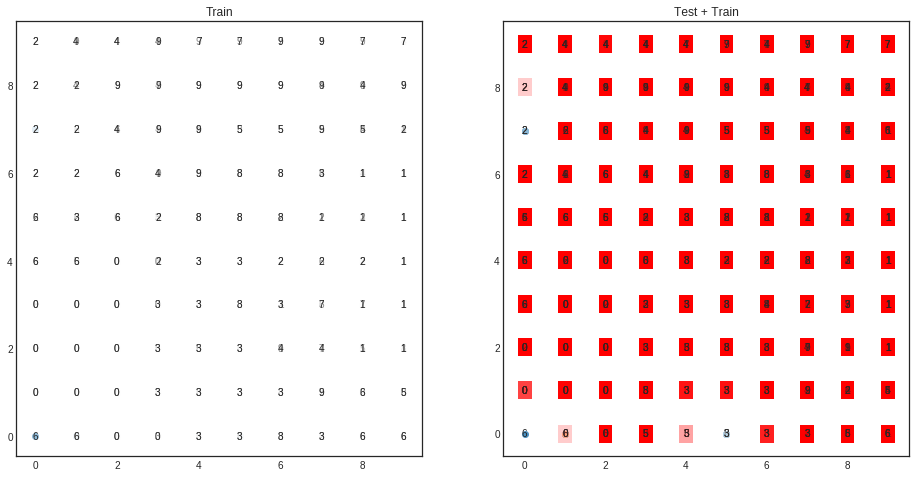

In [0]:
doTask(map_height=10, map_width=10, map_dim=784 , num_epoch=100, batch_size=100)


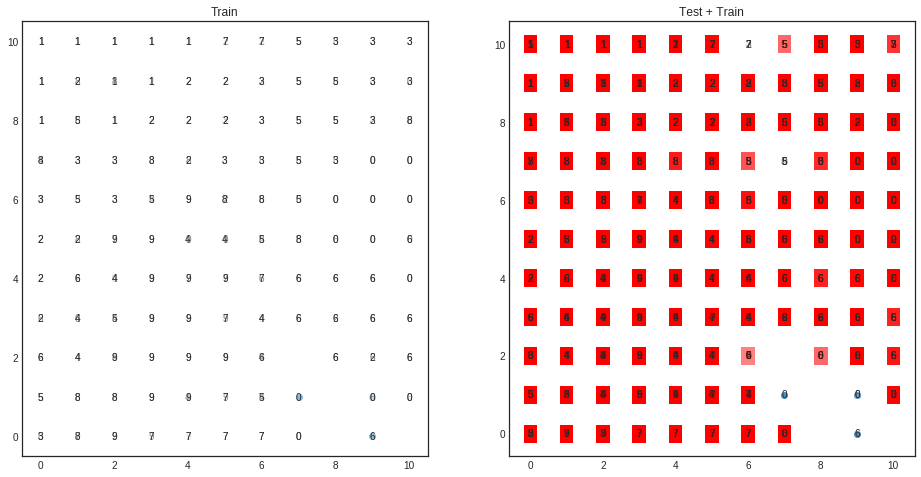

In [0]:
doTask(map_height=11, map_width=11, map_dim=784 , num_epoch=100, batch_size=100)


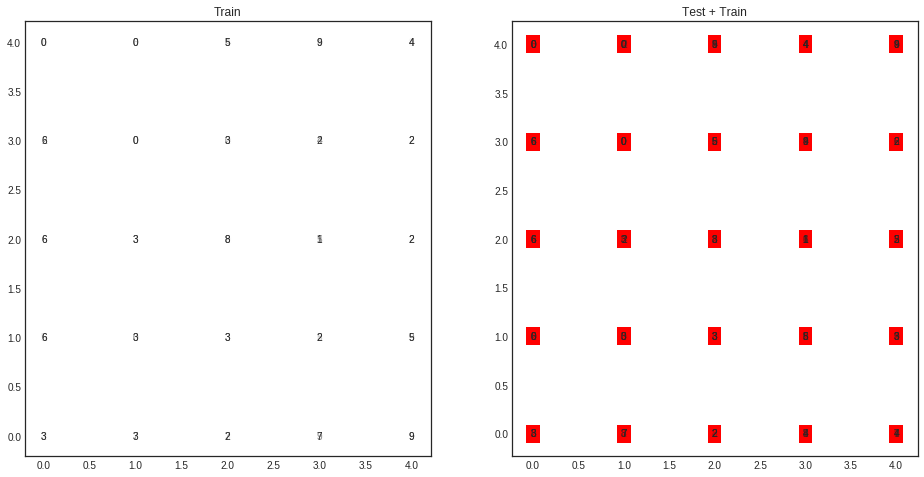

In [0]:
doTask(map_height=5, map_width=5, map_dim=784 , num_epoch=100, batch_size=100)


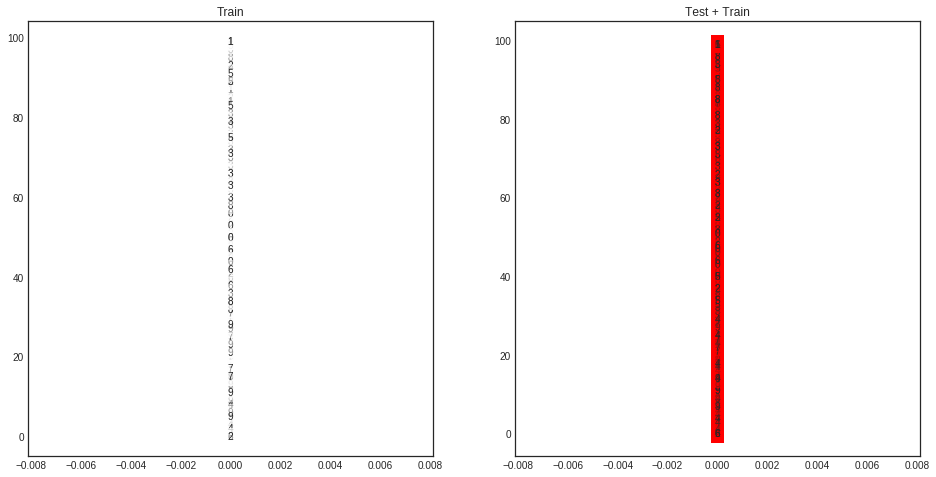

In [0]:
doTask(map_height=1, map_width=100, map_dim=784 , num_epoch=100, batch_size=100)


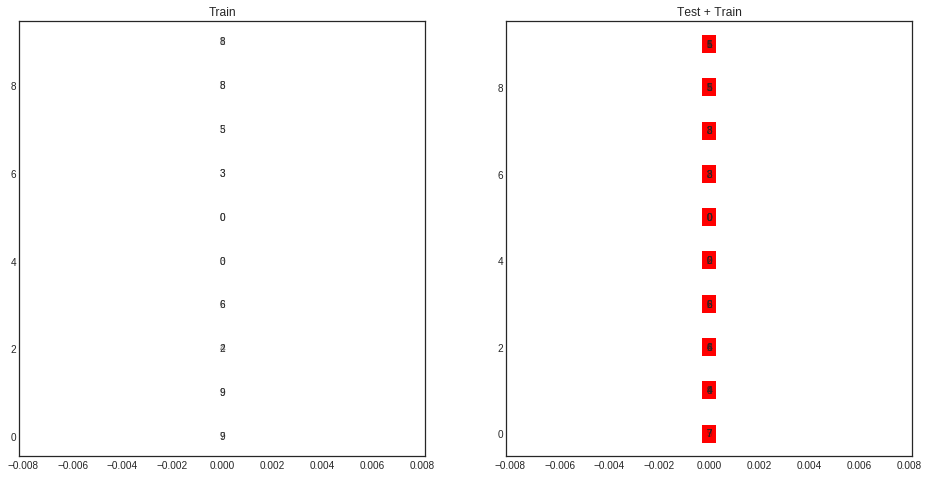

In [0]:
doTask(map_height=1, map_width=10, map_dim=784 , num_epoch=100, batch_size=100)
